# Training

In [26]:
import pandas as pd
import numpy as np
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm
import seaborn as sns
import random

In [2]:
train_path = "../data/train/"

### Tansformation

In [3]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load Data

In [4]:
train_labels = pd.read_csv("../data/train_labels.csv")

In [5]:
train_labels['img_path'] = train_path + train_labels[['id']] + '.tif'

In [6]:
train_labels.head()

,id,label,img_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/train/f38a6374c348f90b587e046aac607995...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/train/c18f2d887b7ae4f6742ee445113fa1ae...
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/train/755db6279dae599ebb4d39a9123cce43...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/train/bc3f0c64fb968ff4a8bd33af6971ecae...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/train/068aba587a4950175d04c680d38943fd...


In [7]:
total_images = train_labels.shape[0]

#### Train and Validation Data

In [8]:
train, test_index = train_test_split(train_labels.index, test_size=0.20)

In [9]:
train_index, validation_index = train_test_split(train_labels.index, test_size=0.05)

In [10]:
print(train_index.shape)
print(validation_index.shape)

(209023,)
(11002,)


### Pytorch Data Generator

In [11]:
class DataGenerator(data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        label = self.dataset['label'][index]
        
        img_raw = imread(self.dataset['img_path'][index])
        img = self.transform(img_raw)
        
        return img, label

In [12]:
class DataGenerator_test(data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, index):
        label = self.dataset['label'][index]
        
        img_raw = imread(self.dataset['img_path'][index])
        img = self.transform(img_raw)       
        img_id = self.dataset['id'][index]
        
        return img, label, img_id

## Model

In [13]:
model = torchvision.models.resnet34(pretrained=False)

## Custom Fully connected Layer

In [14]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1),
    torch.nn.Sigmoid()
)

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Hyperparameters

In [16]:
epochs = 2
batch_size = 64

## Data Loaders

In [17]:
train_data = DataGenerator(train_labels, transform=transform)

In [18]:
train_loader = data.DataLoader(train_data, batch_size=batch_size,
                              sampler= data.SubsetRandomSampler(train_index))

In [19]:
valid_loader = data.DataLoader(train_data, batch_size=batch_size,
                              sampler= data.SubsetRandomSampler(validation_index))

In [20]:
print(len(valid_loader))
print(len(train_loader))

172
3266


### Train Model

In [21]:
## USE GPU ##
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

print_every = 100

loss_sum = 0
correct_sum = 0
samples = 0
sum_precision = 0
sum_recall = 0
valid_count = 0
total_train_batch = 0



train_metrics = []
valid_metrics = []

for epoch in range(epochs):
    ## Training
    batch = 1
    model.train()
    for x, y in train_loader:
        
        total_train_batch += 1
        x = x.cuda()
        y = y.cuda()
        y = y.view(-1, 1).float()
        
        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        samples += x.shape[0]
        loss_sum += loss.item() * x.shape[0] 
        y_pred = (output >= 0.5).float()
        num_corrects = torch.sum(y_pred == y)
        correct_sum += num_corrects
  
        precision = precision_score(y.to('cpu'), y_pred.to('cpu'))
        recall = recall_score(y.to('cpu'), y_pred.to('cpu'))
        sum_precision += precision
        sum_recall += recall
        
        if batch % 500 == 0:
            torch.save(model.state_dict(), 'checkpoint_{0}.pth'.format(batch))
            
        if (batch % print_every == 0) or (batch == 1):
            train_loss = float(loss_sum)/float(samples)
            train_acc = float(correct_sum)/float(samples)
            train_prec = float(sum_precision)/float(total_train_batch)
            train_rec = float(sum_recall)/float(total_train_batch)
            train_metrics.append([epoch+1, total_train_batch, train_loss, train_acc, train_prec, train_rec])
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Batch {batch}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Train acc: {train_acc:.3f}.. "
                  f"Train avg precision: {train_prec:.3f}.. "
                  f"Train avg recall: {train_rec:.3f}.. ")
            
            model.eval()
            with torch.no_grad():
                val_loss_sum = 0
                val_precision_sum = 0
                val_recall_sum = 0
                val_samples = 0
                val_batch = 1
                
                for x_val, y_val in valid_loader:
                    x_val = x_val.cuda()
                    y_val = y_val.cuda()
                    y_val = y_val.view(-1, 1).float()

                    output_val = model(x_val)
                    loss_val = criterion(output_val, y_val)
                    y_val_pred = (output_val >= 0.5).float()

                    val_samples += x_val.shape[0]
                    val_loss_sum += loss_val.item() * x_val.shape[0]

                    val_precision = precision_score(y_val.to('cpu'), y_val_pred.to('cpu'))
                    val_recall = recall_score(y_val.to('cpu'), y_val_pred.to('cpu'))
                    val_precision_sum += val_precision
                    val_recall_sum += val_recall
                    val_batch+=1


                val = float(val_loss_sum)/float(val_samples)
                prec = float(val_precision_sum)/float(val_batch)
                rec = float(val_recall_sum)/float(val_batch)

                valid_metrics.append([epoch+1, val, prec, rec])
                        
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Valid loss: {val:.3f}.. "
                      f"Valid avg presision: {prec:.3f}.. "
                      f"Valid avg recall: {rec:.3f}.. ")
            model.train()
                
            
        batch +=1


/home/erick/anaconda3/envs/histopathologic_cancer/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/2.. Batch 1.. Train loss: 0.682.. Train acc: 0.516.. Train avg precision: 0.000.. Train avg recall: 0.000.. 
Epoch 1/2.. Valid loss: 10.995.. Valid avg presision: 0.000.. Valid avg recall: 0.000.. 
Epoch 1/2.. Batch 100.. Train loss: 0.510.. Train acc: 0.777.. Train avg precision: 0.765.. Train avg recall: 0.683.. 
Epoch 1/2.. Valid loss: 0.450.. Valid avg presision: 0.856.. Valid avg recall: 0.564.. 
Epoch 1/2.. Batch 200.. Train loss: 0.469.. Train acc: 0.792.. Train avg precision: 0.775.. Train avg recall: 0.708.. 
Epoch 1/2.. Valid loss: 0.431.. Valid avg presision: 0.749.. Valid avg recall: 0.775.. 
Epoch 1/2.. Batch 300.. Train loss: 0.452.. Train acc: 0.798.. Train avg precision: 0.782.. Train avg recall: 0.715.. 
Epoch 1/2.. Valid loss: 0.379.. Valid avg presision: 0.829.. Valid avg recall: 0.738.. 
Epoch 1/2.. Batch 400.. Train loss: 0.438.. Train acc: 0.804.. Train avg precision: 0.788.. Train avg recall: 0.725.. 
Epoch 1/2.. Valid loss: 0.404.. Valid avg presision: 0

In [22]:
torch.save(model.state_dict(), 'checkpoint_final_20200309.pth')

In [23]:
np.save("train_metrics", train_metrics)
np.save("valid_metrics", valid_metrics)

In [66]:
np.save("train_index", train_index)
np.save("validation_index", validation_index)
np.save("test_index", test_index)

## Model Evaluation

In [30]:
train_metrics = np.array(train_metrics)

In [41]:
valid_metrics = np.array(valid_metrics)

In [72]:
metrics = pd.DataFrame(train_metrics, 
                       columns=["epoch", "batch", "loss", "accuracy",
                                "Avg. Precision", "Avg. Recall"])

In [73]:
metrics["valid_loss"] = valid_metrics[:,1]
metrics["Avg. Valid. Presision"] = valid_metrics[:,2]
metrics["Avg. Valid Recall"] = valid_metrics[:,3]

In [74]:
metrics.head()

,epoch,batch,loss,accuracy,Avg. Precision,Avg. Recall,valid_loss,Avg. Valid. Presision,Avg. Valid Recall
0,1.0,1.0,0.681884,0.515625,0.000000,0.000000,10.995147,0.000000,0.000000
1,1.0,100.0,0.510069,0.777344,0.765483,0.683180,0.449547,0.856393,0.563722
2,1.0,200.0,0.468627,0.791641,0.775397,0.707732,0.431058,0.749245,0.774731
3,1.0,300.0,0.452065,0.797604,0.781523,0.715224,0.379193,0.828806,0.737856
4,1.0,400.0,0.438013,0.804375,0.788064,0.724860,0.404495,0.889267,0.598033


### Training Metrics

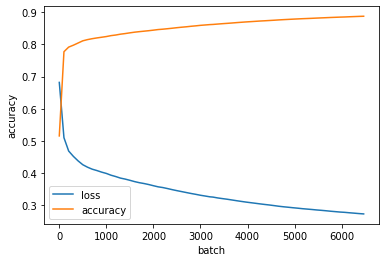

In [75]:
sns.lineplot(y="loss", x="batch", label='loss', data=metrics)
sns.lineplot(y="accuracy", x="batch", label='accuracy', data=metrics)

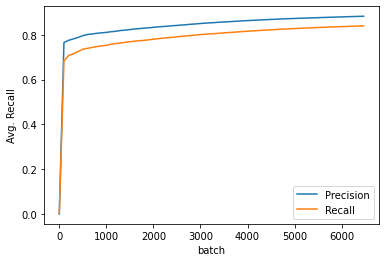

In [76]:
sns.lineplot(y="Avg. Precision", x="batch", label='Precision', data=metrics)
sns.lineplot(y="Avg. Recall", x="batch", label='Recall', data=metrics)

### Validation Metrics

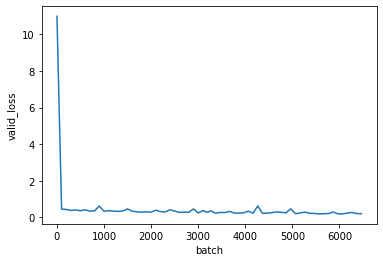

In [58]:
sns.lineplot(y="valid_loss", x="batch", data=metrics)

# TEST MODEL PREDICTIONS

In [ ]:
model_test = torchvision.models.resnet34(pretrained=False)

In [ ]:
model_test.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1),
    torch.nn.Sigmoid()
)

In [ ]:
model_test.load_state_dict(torch.load("checkpoint_final_20200309.pth))

### Test dataloader

In [ ]:
test_labels = train_labels[train_labels.index.isin(validation_index)]

In [ ]:
test_data = DataGenerator_test(test_labels, transform=transform)
test_loader = data.DataLoader(test_data, batch_size=batch_size, 
                              sampler=data.Subset(validation_index))

In [ ]:
len(test_loader)

In [ ]:
## USE GPU
model_test = model_test.cuda()

predictions = []
model_test.eval()
total_test_batches = len(test_loader)
img_ids = []
for x,y, ids in tqdm(test_loader, total = total_test_batches):
    x = x.cuda()
    y = y.cuda()
    y = y.view(-1, 1).float()
    img_ids.append(ids)
    
    with torch.no_grad():
        out = model_test(x)
        predictions.append((out >= 0.5).float().cpu().numpy())

In [ ]:
y_hat = []
for i in range(len(predictions)):
    for val in predictions[i]:
        y_hat.append(int(val[0]))
        
img_pred_id = []
for i in range(len(img_ids)):
    for val in img_ids[i]:
        img_pred_id.append(val)

In [ ]:
img_pred_id[0]

In [ ]:
test_labels[test_labels.id == '49eb20a0608511777074a59d62610fd63a2229bf']